In [1]:
import requests
import json
import time
import base64
from typing import Optional, Dict, Any


In [2]:
try:
    from IPython.display import Image, display, HTML
    JUPYTER_AVAILABLE = True
    print("📱 Jupyter environment detected - image display enabled")
except ImportError:
    JUPYTER_AVAILABLE = False
    print("📱 Standard environment - HTML image display")


📱 Jupyter environment detected - image display enabled


In [ ]:
# API Configuration
BASE_URL = "XXX"  # Replace with your API URL
API_KEY = "XXX"  # Replace with your API key

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "accept": "application/json"
}

# 1. DISCOVERING AVAILABLE MODELS

Let's start by looking at the models available on Albert API

In [4]:
def get_available_models():
    """Retrieves the list of available models."""
    try:
        response = requests.get(f"{BASE_URL}/v1/models", headers=headers)
        response.raise_for_status()
        models_data = response.json()
        
        print(f"✅ {len(models_data['data'])} models found")
        
        for model in models_data['data']:
            print(f"  📱 {model.get('id', 'N/A')}")
            print(f"     Type: {model.get('type', 'N/A')}")
            
            # Handle max context which can be None
            max_context = model.get('max_context_length')
            if max_context is not None:
                print(f"     Max context: {max_context:,} tokens")
            else:
                print(f"     Max context: N/A")
                
            # Handle costs which can be None or missing
            costs = model.get('costs')
            if costs and isinstance(costs, dict):
                prompt_cost = costs.get('prompt_tokens', 'N/A')
                completion_cost = costs.get('completion_tokens', 'N/A')
                print(f"     Prompt cost: {prompt_cost}")
                print(f"     Completion cost: {completion_cost}")
            else:
                print(f"     Costs: Not available")
            print()
        
        return models_data['data']
    except requests.exceptions.RequestException as e:
        print(f"❌ Error retrieving models: {e}")
        return []

models = get_available_models()

✅ 5 models found
  📱 albert-large
     Type: image-text-to-text
     Max context: 128,000 tokens
     Prompt cost: 0.0
     Completion cost: 0.0

  📱 albert-small
     Type: text-generation
     Max context: 64,000 tokens
     Prompt cost: 0.0
     Completion cost: 0.0

  📱 embeddings-small
     Type: text-embeddings-inference
     Max context: 8,192 tokens
     Prompt cost: 0.0
     Completion cost: 0.0

  📱 audio-large
     Type: automatic-speech-recognition
     Max context: N/A
     Prompt cost: 0.0
     Completion cost: 0.0

  📱 rerank-small
     Type: text-classification
     Max context: 8,192 tokens
     Prompt cost: 0.0
     Completion cost: 0.0



We select the albert-small and embeddings-small models for our example.

In [5]:
# Search for specific desired models
preferred_chat_model = "albert-small"
preferred_embedding_model = "embeddings-small"

# Search for specific chat model
chat_model = None
for model in models:
    if model.get('id') == preferred_chat_model:
        chat_model = preferred_chat_model
        break

# Search for specific embedding model
embedding_model = None
for model in models:
    if model.get('id') == preferred_embedding_model:
        embedding_model = preferred_embedding_model
        break

# If preferred models are not found, use the first available ones as fallback
if not chat_model and models:
    chat_model = models[0].get('id', '')
    print(f"⚠️  Model '{preferred_chat_model}' not found, using first available model")

if not embedding_model and models:
    # Look for an embedding model in the list, otherwise take the first one
    for model in models:
        if 'embedding' in model.get('id', '').lower():
            embedding_model = model.get('id', '')
            break
    if not embedding_model:
        embedding_model = models[0].get('id', '')
        print(f"⚠️  Model '{preferred_embedding_model}' not found, using first available model")

print(f"🎯 Selected embedding model: {embedding_model or 'None found'}")
print(f"🎯 Selected chat model: {chat_model or 'None found'}")

if not chat_model:
    print("❌ No chat model available. Please check your API configuration.")
    print("📋 Available models:", [m.get('id') for m in models])

🎯 Selected embedding model: embeddings-small
🎯 Selected chat model: albert-small


# 2. DOWNLOADING AND PARSING PDF

We are going to download a PDF document that will serve as an example. To do this, we will use the Wikipedia API which will allow us to retrieve the PDF format of this page https://fr.wikipedia.org/wiki/%C3%89lectron .
We will use the parse endpoint to look at the results of our parsing tool and verify that the result is satisfactory. 

In [6]:
def download_wikipedia_pdf() -> Optional[Dict[str, Any]]:
    """Downloads a PDF from the Wikipedia API and parses it with the API."""
    try:
        # Download PDF from Wikipedia REST API
        print("⬇️  Downloading Wikipedia PDF on electron...")
        
        # Direct URL from Wikipedia REST API to download as PDF
        wikipedia_url = "https://fr.wikipedia.org/api/rest_v1/page/pdf/Électron"
        
        headers = {
            'User-Agent': 'Mozilla/5.0 (compatible; Albert-API-Demo/1.0)'
        }
        
        pdf_response = requests.get(wikipedia_url, headers=headers, timeout=30)
        pdf_response.raise_for_status()
        
        print("✅ PDF downloaded successfully!")
        print(f"📊 PDF size: {len(pdf_response.content):,} bytes")
        
        # Parsing with Albert API
        print("🔄 Parsing PDF with Albert API...")
        
        files = {
            'file': ('electron_wikipedia.pdf', pdf_response.content, 'application/pdf')
        }
        
        parse_data = {
            'output_format': 'markdown',
            'force_ocr': 'false',
            'languages': 'fr',
            'use_llm': 'false'
        }
        
        parse_response = requests.post(
            f"{BASE_URL}/v1/parse",
            headers={"Authorization": f"Bearer {API_KEY}"},
            files=files,
            data=parse_data
        )
        parse_response.raise_for_status()
        
        parsed_data = parse_response.json()
        print("✅ PDF parsed successfully!")
        
        # Display content preview
        if parsed_data.get('data') and len(parsed_data['data']) > 0:
            content = parsed_data['data'][0]['content']
            print(f"📝 Content preview ({len(content)} characters):")
            print(content[:300] + "..." if len(content) > 300 else content)
        
        return parsed_data
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error during download/parsing: {e}")
        print("🔄 Attempting alternative solution...")
        
        # Fallback solution: use test content on electron
        try:
            print("📄 Using alternative test document...")
            test_content = """
# The Electron

The electron is a stable elementary particle from the lepton family. 
It carries a negative elementary electric charge and has a rest mass 
of approximately 9.109 × 10⁻³¹ kg. The electron plays a fundamental role in chemistry, 
as it participates in chemical bonds.

## Main properties
- Charge: -1.602 × 10⁻¹⁹ coulombs
- Mass: 9.109 × 10⁻³¹ kg
- Spin: 1/2

## Discovery
The electron was discovered by J.J. Thomson in 1897.

## Atomic structure
The electron orbits around the atomic nucleus and determines the chemical properties of elements.
            """
            
            return {
                'data': [{
                    'content': test_content.strip(),
                    'images': {},
                    'metadata': {'document_name': 'electron_test.txt', 'page': 0}
                }]
            }
            
        except Exception as fallback_error:
            print(f"❌ Fallback error: {fallback_error}")
            return None

In [7]:
parsed_pdf = download_wikipedia_pdf()


⬇️  Downloading Wikipedia PDF on electron...
✅ PDF downloaded successfully!
📊 PDF size: 2,147,884 bytes
🔄 Parsing PDF with Albert API...
✅ PDF parsed successfully!
📝 Content preview (9149 characters):
![](_page_0_Picture_0.jpeg)

## **Électron**

L'**électron**, un des composants de l'[atome](https://fr.wikipedia.org/wiki/Atome) avec les [neutrons](https://fr.wikipedia.org/wiki/Neutron) et les [protons,](https://fr.wikipedia.org/wiki/Proton) est une [particule élémentaire](https://fr.wikipedia.or...


# 2.5. DETAILED DISPLAY OF PARSED CONTENT

Let's display the obtained result

📄 === FIRST PAGE ===

📝 MARKDOWN CONTENT (9149 characters):
![](_page_0_Picture_0.jpeg)

## **Électron**

L'**électron**, un des composants de l'[atome](https://fr.wikipedia.org/wiki/Atome) avec les [neutrons](https://fr.wikipedia.org/wiki/Neutron) et les [protons,](https://fr.wikipedia.org/wiki/Proton) est une [particule élémentaire](https://fr.wikipedia.org/wiki/Particule_%C3%A9l%C3%A9mentaire) qui possède une [charge élémentaire](https://fr.wikipedia.org/wiki/Charge_%C3%A9l%C3%A9mentaire) de signe négatif. Il est fondamental en [chimie,](https://fr.wikipedia.org/wiki/Chimie) car il participe à presque tous les types de [réactions chimiques](https://fr.wikipedia.org/wiki/R%C3%A9action_chimique) et constitue un élément primordial des [liaisons](https://fr.wikipedia.org/wiki/Liaison_chimique) présentes dans les [molécules](https://fr.wikipedia.org/wiki/Mol%C3%A9cule). En [physique,](https://fr.wikipedia.org/wiki/Physique) l'électron intervient dans une multitude de [rayonnements](https

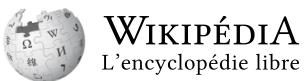


📸 Image: _page_0_Picture_8.jpeg
   ✅ Image decoded: 15,741 bytes


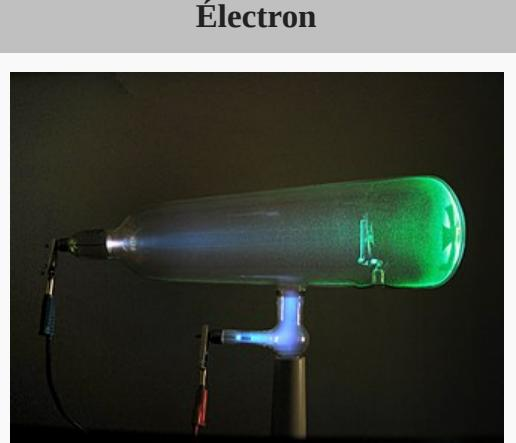



📊 MAIN METADATA:
------------------------------
   📄 Document: electron_wikipedia.pdf
   📝 Page: 0

📋 TABLE OF CONTENTS (2 entries):
   1. Électron (level: None)
   2. Histoire (level: None)

🔧 PARSING:
   Method: pdftext
   Detected blocks: 7



In [8]:
def display_first_page_content(parsed_data: Dict[str, Any]):
    """Displays the content of the first page in detail with images."""
    if not parsed_data or not parsed_data.get('data'):
        print("❌ No parsed content available")
        return
    
    # Take only the first page
    page_data = parsed_data['data'][0]
    
    print(f"📄 === FIRST PAGE ===")
    
    # Display markdown content
    content = page_data.get('content', '')
    print(f"\n📝 MARKDOWN CONTENT ({len(content)} characters):")
    print("=" * 60)
    print(content)
    print("=" * 60)
    
    # Display images
    images = page_data.get('images', {})
    if images:
        print(f"\n🖼️  DETECTED IMAGES ({len(images)} images):")
        print("-" * 40)
        
        # Import libraries to display images
        if JUPYTER_AVAILABLE:
            # Jupyter environment - direct image display
            for img_name, img_data in images.items():
                print(f"📸 Image: {img_name}")
                
                try:
                    # Decode base64 image
                    img_bytes = base64.b64decode(img_data)
                    print(f"   ✅ Image decoded: {len(img_bytes):,} bytes")
                    
                    # Display image in Jupyter
                    display(Image(data=img_bytes))
                    
                except Exception as e:
                    print(f"   ❌ Image decoding error {img_name}: {e}")
                    print(f"   Type: {'JPEG' if img_data.startswith('/9j/') else 'PNG/Other'}")
                    print(f"   Base64 size: {len(img_data):,} characters")
                    
                print()
        else:
            # Standard environment - HTML display
            print("⚠️  HTML image display (copy HTML code into a browser):")
            
            for img_name, img_data in images.items():
                print(f"📸 Image: {img_name}")
                
                # Determine image format
                if img_data.startswith('/9j/'):
                    img_format = "jpeg"
                elif img_data.startswith('iVBOR'):
                    img_format = "png"
                else:
                    img_format = "jpeg"  # Default
                
                print(f"   Type: {img_format.upper()}")
                print(f"   Base64 size: {len(img_data):,} characters")
                
                # Create an HTML tag to display the image
                html_img = f'<img src="data:image/{img_format};base64,{img_data}" style="max-width:500px; max-height:400px; border:1px solid #ccc; margin:10px;" alt="{img_name}">'
                print(f"   📋 HTML code for display:")
                print(f"   {html_img}")
                print()
    else:
        print("🖼️  No images detected on this page")
    
    # Display important metadata
    metadata = page_data.get('metadata', {})
    if metadata:
        print(f"\n📊 MAIN METADATA:")
        print("-" * 30)
        
        # Basic information
        doc_name = metadata.get('document_name', 'N/A')
        page_num = metadata.get('page', 'N/A')
        print(f"   📄 Document: {doc_name}")
        print(f"   📝 Page: {page_num}")
        
        # Table of contents if present
        if 'table_of_contents' in metadata and metadata['table_of_contents']:
            toc = metadata['table_of_contents']
            print(f"\n📋 TABLE OF CONTENTS ({len(toc)} entries):")
            for i, entry in enumerate(toc[:5]):  # Limit to 5 entries for the first page
                title = entry.get('title', 'No title')
                level = entry.get('heading_level', 'N/A')
                print(f"   {i+1}. {title} (level: {level})")
            if len(toc) > 5:
                print(f"   ... and {len(toc) - 5} other entries")
        
        # Parsing statistics
        if 'page_stats' in metadata:
            stats = metadata['page_stats']
            if stats and len(stats) > 0:
                page_stat = stats[0]
                method = page_stat.get('text_extraction_method', 'N/A')
                print(f"\n🔧 PARSING:")
                print(f"   Method: {method}")
                
                if 'block_counts' in page_stat:
                    print(f"   Detected blocks: {len(page_stat['block_counts'])}")
    
    print("\n" + "="*60)

if parsed_pdf:
    display_first_page_content(parsed_pdf)
else:
    print("❌ Unable to display content - parsing failed")

# 3. CREATING A COLLECTION

We are satisfied with the result of the first page, now we are going to store the document text in the database using the document endpoint. First, we need to create a collection using the collection endpoint.

In [9]:
def create_collection(name: str, description: str) -> Optional[str]:
    """Creates a new collection."""
    try:
        collection_data = {
            "name": name,
            "description": description,
            "visibility": "private"
        }
        
        response = requests.post(
            f"{BASE_URL}/v1/collections",
            headers={**headers, "Content-Type": "application/json"},
            json=collection_data
        )
        response.raise_for_status()
        
        collection_id = response.json()
        print(f"✅ Collection created with ID: {collection_id}")
        return collection_id
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error creating collection: {e}")
        return None

collection_id = create_collection(
    "Physical Sciences", 
    "Collection for storing and analyzing scientific documents"
)

✅ Collection created with ID: {'id': 4}


# 4. ADDING THE DOCUMENT TO THE COLLECTION

In [10]:
def add_document_to_collection(collection_id: Any) -> Optional[Dict[str, Any]]:
    """Downloads the Wikipedia PDF and adds it directly to a collection for embedding."""
    try:
        print("⬇️  Re-downloading Wikipedia PDF to add to collection...")
        
        # Re-download PDF from Wikipedia REST API
        wikipedia_url = "https://fr.wikipedia.org/api/rest_v1/page/pdf/Électron"
        
        headers = {
            'User-Agent': 'Mozilla/5.0 (compatible; Albert-API-Demo/1.0)'
        }
        
        pdf_response = requests.get(wikipedia_url, headers=headers, timeout=30)
        pdf_response.raise_for_status()
        
        print(f"✅ PDF re-downloaded: {len(pdf_response.content):,} bytes")
        
        # Send PDF directly to documents endpoint
        # Use all required parameters according to documentation
        files = {
            'file': ('electron_wikipedia.pdf', pdf_response.content, 'application/pdf')
        }
        
        # Complete parameters according to documentation
        # Note: for multipart/form-data, all parameters must be strings
        # Extract ID if collection_id is a dictionary
        collection_int_id = collection_id['id'] if isinstance(collection_id, dict) and 'id' in collection_id else collection_id
        
        data = {
            'collection': str(collection_int_id),  # Extract ID from dictionary and convert to string
            'output_format': 'markdown',
            'force_ocr': 'false',
            'languages': 'fr',
            'chunk_size': '1000',
            'chunk_overlap': '200',
            'use_llm': 'false',
            'paginate_output': 'false',
            'chunker': 'RecursiveCharacterTextSplitter',
            'length_function': 'len',
            'chunk_min_size': '0',
            'is_separator_regex': 'false',
            'metadata': ''
        }
        
        print("📤 Sending PDF to documents endpoint for parsing and embedding...")
        print(f"🔧 Parameters: collection={data['collection']}, chunk_size={data['chunk_size']}")
        
        response = requests.post(
            f"{BASE_URL}/v1/documents",
            headers={"Authorization": f"Bearer {API_KEY}"},
            files=files,
            data=data
        )
        
        # Debug: display error details if it persists
        if not response.ok:
            print(f"❌ HTTP Error {response.status_code}")
            try:
                error_detail = response.json()
                print(f"📋 Error details: {error_detail}")
            except:
                print(f"📋 Raw response: {response.text}")
        
        response.raise_for_status()
        
        document_data = response.json()
        print(f"✅ Document added with ID: {document_data['id']}")
        print("🔄 Albert API performed parsing and embedding automatically")
        return document_data
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error adding document: {e}")
        
        # Fallback with test content
        try:
            print("🔄 Using test content as fallback...")
            
            test_content = """# The Electron

The electron is a stable elementary particle from the lepton family. 
It carries a negative elementary electric charge and has a rest mass 
of approximately 9.109 × 10⁻³¹ kg. The electron plays a fundamental role in chemistry, 
as it participates in chemical bonds.

## Main properties
- Charge: -1.602 × 10⁻¹⁹ coulombs
- Mass: 9.109 × 10⁻³¹ kg
- Spin: 1/2

## Discovery
The electron was discovered by J.J. Thomson in 1897.

## Atomic structure
The electron orbits around the atomic nucleus and determines the chemical properties of elements.
It participates in ionic and covalent bonds that form molecules."""
            
            file_content = test_content.encode('utf-8')
            
            files = {
                'file': ('electron_test.txt', file_content, 'text/plain')
            }
            
            data = {
                'collection': str(collection_int_id),  # Use the same extracted ID
                'chunk_size': '1000',
                'chunk_overlap': '200',
                'chunker': 'RecursiveCharacterTextSplitter',
                'length_function': 'len',
                'chunk_min_size': '0',
                'is_separator_regex': 'false',
                'metadata': ''
            }
            
            response = requests.post(
                f"{BASE_URL}/v1/documents",
                headers={"Authorization": f"Bearer {API_KEY}"},
                files=files,
                data=data
            )
            
            if not response.ok:
                print(f"❌ Fallback HTTP Error {response.status_code}")
                try:
                    error_detail = response.json()
                    print(f"📋 Fallback error details: {error_detail}")
                except:
                    print(f"📋 Raw fallback response: {response.text}")
            
            response.raise_for_status()
            
            document_data = response.json()
            print(f"✅ Test document added with ID: {document_data['id']}")
            return document_data
            
        except Exception as fallback_error:
            print(f"❌ Fallback error: {fallback_error}")
            return None

if collection_id:
    document_data = add_document_to_collection(collection_id)
    
    # Wait a bit for embedding to complete
    print("⏳ Waiting for embedding process to complete...")
    time.sleep(5)

⬇️  Re-downloading Wikipedia PDF to add to collection...
✅ PDF re-downloaded: 2,147,884 bytes
📤 Sending PDF to documents endpoint for parsing and embedding...
🔧 Parameters: collection=4, chunk_size=1000
✅ Document added with ID: 6
🔄 Albert API performed parsing and embedding automatically
⏳ Waiting for embedding process to complete...


# 5. SEMANTIC SEARCH

We use the search endpoint which allows us to retrieve the results that are semantically closest to the question in the collection.

In [11]:
def semantic_search(query: str, collection_id: Any, k: int = 5) -> Optional[Dict[str, Any]]:
    """Performs a semantic search in the collection."""
    try:
        # Extract ID if collection_id is a dictionary
        collection_int_id = collection_id['id'] if isinstance(collection_id, dict) and 'id' in collection_id else collection_id
        
        search_data = {
            "collections": [collection_int_id],  # Use extracted ID
            "prompt": query,
            "k": k,
            "method": "semantic",
            "score_threshold": 0.1
        }
        
        response = requests.post(
            f"{BASE_URL}/v1/search",
            headers={**headers, "Content-Type": "application/json"},
            json=search_data
        )
        response.raise_for_status()
        
        search_results = response.json()
        print(f"✅ Search performed: {len(search_results['data'])} results found")
        
        for i, result in enumerate(search_results['data'][:3], 1):
            print(f"\n📄 Result {i} (score: {result['score']:.3f}):")
            print(f"   {result['chunk']['content'][:200]}...")
        
        return search_results
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error during search: {e}")
        return None

In [12]:
QUESTION = "Quelles sont les principales propriétés physiques de l'électron et qui l'a découvert ?"
print(f"❓ Question: {QUESTION}")

if collection_id:
    search_results = semantic_search(QUESTION, collection_id)

❓ Question: Quelles sont les principales propriétés physiques de l'électron et qui l'a découvert ?
✅ Search performed: 5 results found

📄 Result 1 (score: 0.647):
   . Il montre que le rapport charge sur masse *e/m* est indépendant de la matière de la cathode. Il montre de plus que les particules chargées négativement produites par les matériaux radioactifs, les m...

📄 Result 2 (score: 0.636):
   En 1887, l'[effet photoélectrique](https://fr.wikipedia.org/wiki/Effet_photo%C3%A9lectrique) est observé par [Heinrich Hertz](https://fr.wikipedia.org/wiki/Heinrich_Hertz) alors qu'il étudie les [onde...

📄 Result 3 (score: 0.632):
   En 1894, Stoney invente le terme d'« électron » pour désigner ces charges élémentaires, écrivant « […] une estimation a été faite de la valeur réelle de cette unité fondamentale très remarquable d'éle...


# 6. RESPONSE GENERATION WITH RAG

We can also use the chat/completion endpoint with RAG enabled on the collection to directly generate the answer to the question.

In [13]:

def chat_with_rag(question: str, collection_id: Any, chat_model: str) -> Optional[str]:
    """Utilise le chat completion avec RAG activé."""
    try:
        # Extraire l'ID si collection_id est un dictionnaire
        collection_int_id = collection_id['id'] if isinstance(collection_id, dict) and 'id' in collection_id else collection_id
        
        chat_data = {
            "messages": [
                {
                    "role": "user",
                    "content": question
                }
            ],
            "model": chat_model,
            "temperature": 0.3,
            "max_completion_tokens": 500,
            "search": True,
            "search_args": {
                "collections": [collection_int_id],  # Utiliser l'ID extrait
                "k": 5,
                "method": "semantic",
                "score_threshold": 0.1,
                "template": "Réponds à la question suivante en te basant sur les documents ci-dessous : {prompt}\n\nDocuments :\n{chunks}"
            }
        }
        
        response = requests.post(
            f"{BASE_URL}/v1/chat/completions",
            headers={**headers, "Content-Type": "application/json"},
            json=chat_data
        )
        response.raise_for_status()
        
        chat_response = response.json()
        
        if chat_response.get('choices') and len(chat_response['choices']) > 0:
            answer = chat_response['choices'][0]['message']['content']
            print("✅ Réponse générée:")
            print(f"🎯 {answer}")
            
            # Affichage des informations sur l'usage
            if 'usage' in chat_response:
                usage = chat_response['usage']
                print(f"\n📊 Usage:")
                print(f"   Tokens prompt: {usage.get('prompt_tokens', 0)}")
                print(f"   Tokens completion: {usage.get('completion_tokens', 0)}")
                print(f"   Total tokens: {usage.get('total_tokens', 0)}")
                if 'cost' in usage:
                    print(f"   Coût: {usage['cost']}")
            
            # Affichage des résultats de recherche utilisés
            if 'search_results' in chat_response:
                print(f"\n🔍 {len(chat_response['search_results'])} documents utilisés pour le contexte")
            
            return answer
        else:
            print("❌ Aucune réponse générée")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"❌ Erreur lors du chat: {e}")
        return None

if collection_id and chat_model:
    final_answer = chat_with_rag(QUESTION, collection_id, chat_model)

✅ Réponse générée:
🎯 Selon les documents fournis, les principales propriétés physiques de l'électron sont :

1.  Il possède un spin, ce qui est décrit par le principe d'exclusion de Pauli.
2.  Il présente une dualité onde-corpuscule, ce qui signifie qu'il se comporte à la fois comme une particule et comme une onde.
3.  Il a une longueur d'onde de De Broglie caractéristique donnée par λe = h/p, où h est la constante de Planck et p est la quantité de mouvement.
4.  Il peut être détruit lors de la capture électronique qui survient dans les noyaux d'atomes radioactifs.

Quant à la découverte de l'électron, elle est attribuée à plusieurs scientifiques, notamment :

1.  Le physicien irlandais George F. Fitzgerald, qui propose le nom d'électron avec succès.
2.  Le physicien anglais J.J. Thomson, qui a réalisé des expériences sur la déflexion des rayons cathodiques dans un champ électrique et a montré que les particules chargées négativement produites par les matériaux radioactifs, les matière

# 7. SUMMARY AND CLEANUP

In [14]:
print("✅ Completed steps:")
print("   1. ✓ Retrieved available models")
print("   2. ✓ Downloaded and parsed Wikipedia PDF")
print("   3. ✓ Created a collection")
print("   4. ✓ Added document with embedding")
print("   5. ✓ Semantic search")
print("   6. ✓ Generated response with RAG")

print(f"\n🎯 Question asked: {QUESTION}")
if 'final_answer' in locals() and final_answer:
    print(f"💡 Answer obtained: {final_answer}")

print("\n🧹 Cleanup (optional)")
if collection_id:
    # Extract ID for display
    display_id = collection_id['id'] if isinstance(collection_id, dict) and 'id' in collection_id else collection_id
    print("To delete the created collection, use:")
    print(f"DELETE {BASE_URL}/v1/collections/{display_id}")
else:
    print("No collection created to clean up")

print("\n" + "=" * 50)
print("🎉 Demonstration completed!")
print("This notebook showed how to use the Albert API to:")
print("- Parse PDF documents from Wikipedia")
print("- Create collections and perform embedding")
print("- Perform semantic searches")
print("- Generate contextualized responses with RAG")

✅ Completed steps:
   1. ✓ Retrieved available models
   2. ✓ Downloaded and parsed Wikipedia PDF
   3. ✓ Created a collection
   4. ✓ Added document with embedding
   5. ✓ Semantic search
   6. ✓ Generated response with RAG

🎯 Question asked: Quelles sont les principales propriétés physiques de l'électron et qui l'a découvert ?
💡 Answer obtained: Selon les documents fournis, les principales propriétés physiques de l'électron sont :

1.  Il possède un spin, ce qui est décrit par le principe d'exclusion de Pauli.
2.  Il présente une dualité onde-corpuscule, ce qui signifie qu'il se comporte à la fois comme une particule et comme une onde.
3.  Il a une longueur d'onde de De Broglie caractéristique donnée par λe = h/p, où h est la constante de Planck et p est la quantité de mouvement.
4.  Il peut être détruit lors de la capture électronique qui survient dans les noyaux d'atomes radioactifs.

Quant à la découverte de l'électron, elle est attribuée à plusieurs scientifiques, notamment :

1.